In [1]:
# https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
# (1) from command line ----    git clone https://github.com/matterport/Mask_RCNN.git
#      after clone --- command line --- cd Mask_RCNN
#                              --- (sudo) python setup.py install

# (2) from command line --- get dataset --- git clone https://github.com/experiencor/kangaroo.git
# (3) download the model (below)
    # pip install wget
    #import wget
    #url = 'https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5'
    #wget.download(url, 'mask_rcnn_coco.h5')
    
# (4) pip install tensorflow==1.15.3 #important version 
# (5) # pip install keras==2.2.4    #important version
# (6) # # pip install mrcnn
# train a new object, for example, Kangaroo or something else 

import warnings
warnings.simplefilter("ignore")
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import os

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

sys.path.append('/home/ubuntu/Mask_RCNN/samples/coco') 
import coco
%matplotlib inline

Using TensorFlow backend.


In [ ]:
#Train/Test --- generate model 


class KangarooDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "clown")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('clown'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

class KangarooConfig(Config):
	NAME = "kangaroo_cfg"
	NUM_CLASSES = 1 + 1
	STEPS_PER_EPOCH = 5

train_set = KangarooDataset()
train_set.load_dataset('/home/ubuntu/gitscripts/FobiaPhilter/training', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
test_set = KangarooDataset()
test_set.load_dataset('/home/ubuntu/gitscripts/FobiaPhilter/validation', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
config = KangarooConfig()
config.display()

model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('/home/ubuntu/gitscripts/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

In [ ]:
# Evaluate the test dataset (predict vs. truth)

class KangarooDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "clown")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('clown'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

class PredictionConfig(Config):
	NAME = "kangaroo_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1


def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
         scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

test_set = KangarooDataset()
test_set.load_dataset('/home/ubuntu/gitscripts/FobiaPhilter/validation', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
cfg = PredictionConfig()
model = MaskRCNN(mode = 'inference', model_dir = './', config = cfg)
model.load_weights('/home/ubuntu/gitscripts/FobiaPhilter/kangaroo_cfg20200922T1734/mask_rcnn_kangaroo_cfg_0001.h5', by_name = True)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Processing 1 images
image                    shape: (720, 1280, 3)        min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   33.32501  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


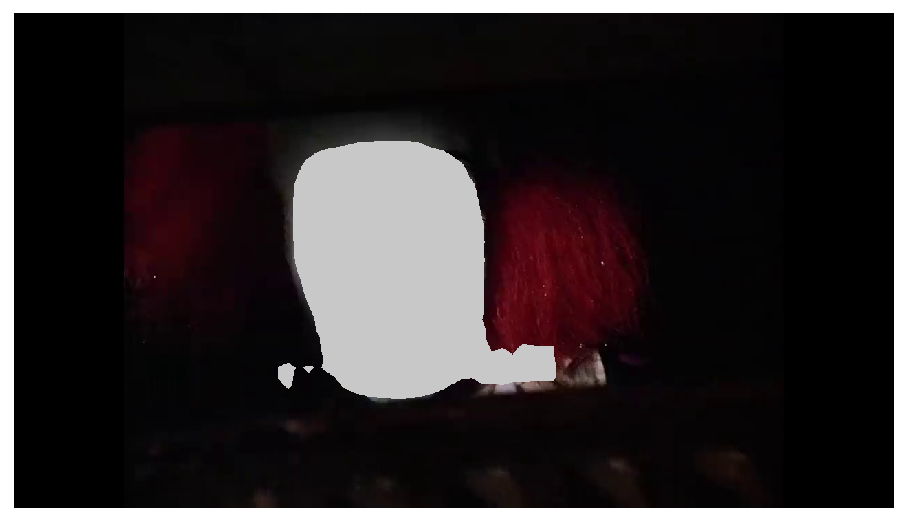

Processing 1 images
image                    shape: (720, 1280, 3)        min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   47.20001  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


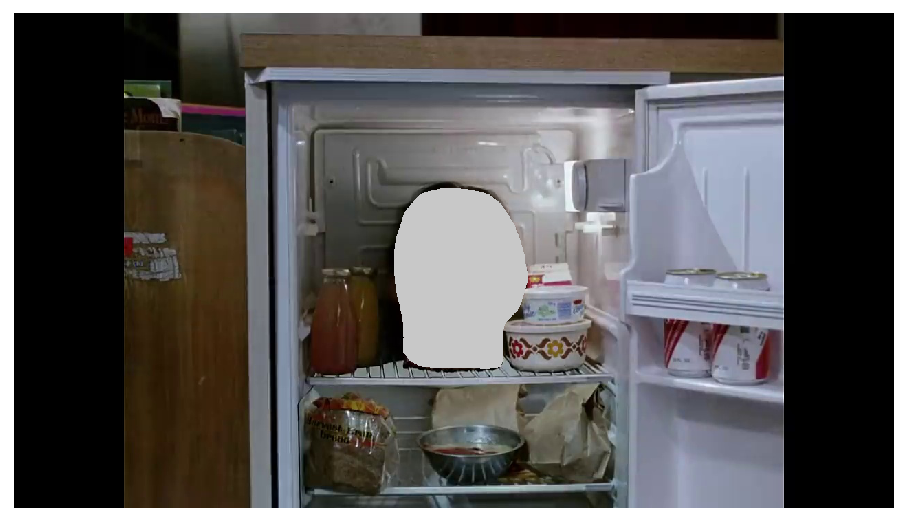

Processing 1 images
image                    shape: (720, 1280, 3)        min: -123.70000  max:  144.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   38.93438  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


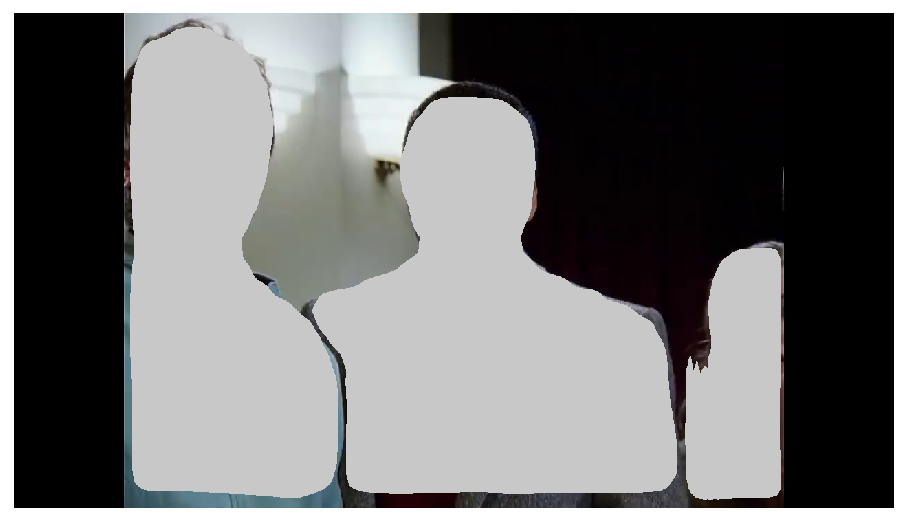

In [189]:
# validate in new images (no annotation), save the images with BB 

import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, imagecount=0):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        #if not captions:
        #    class_id = class_ids[i]
        #    score = scores[i] if scores is not None else None
        #    label = class_names[class_id]
        #    caption = "{} {:.3f}".format(label, score) if score else label
        #else:
        #    caption = captions[i]
        #ax.text(x1, y1 + 8, caption,
        #        color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:                  
            masked_image = apply_mask(masked_image, mask, color)   

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        #padded_mask = np.zeros(
        #    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        #padded_mask[1:-1, 1:-1] = mask
        #contours = find_contours(padded_mask, 0.5)
        #for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
        #    verts = np.fliplr(verts) - 1
        #    p = Polygon(verts, facecolor="none", edgecolor=color)
        #    ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig(f"{imagecount}.jpg", bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape')  #save output
    if auto_show:
        plt.show()

        
        
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors
     
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

        

def changefilename(): 
    for count, filename in enumerate(os.listdir("/home/ubuntu/gitscripts/FobiaPhilter/Frames/images/")):
        newfilename = ''.join([n for n in filename if n.isdigit()]) + ".jpg"
        src = '/home/ubuntu/gitscripts/FobiaPhilter/Frames/images/' + filename
        dst ='/home/ubuntu/gitscripts/FobiaPhilter/Frames/images/' + newfilename    
        os.rename(src, dst) 
         
#if __name__ == '__main__': 
#    changefilename() 

    
class KangarooDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "clown")
		images_dir = dataset_dir + '/images/'    
		l = os.listdir(images_dir)
		#lsorted = sorted(l,key=lambda x: int(os.path.splitext(x)[0]))
		#for filename in lsorted:
		for filename in l:
			image_id = filename[:-4]
			img_path = images_dir + filename
			self.add_image('dataset', image_id=image_id, path=img_path)

	def extract_boxes(self, filename):
		root = ElementTree.parse(filename)
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('clown'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

class PredictionConfig(Config):
	NAME = "kangaroo_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
    
    
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


# plot a number of photos with ground truth and predictions
def plot_predicted_new(dataset, model, cfg, n_images=3):
	for i in range(n_images):
		image = dataset.load_image(i)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
        

        
		#yhat = model.detect(sample, verbose=0)[0]
        
		#class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
		#               'bus', 'train', 'truck', 'boat', 'traffic light',
		#               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
		#               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
		#               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
		#               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
		#               'kite', 'baseball bat', 'baseball glove', 'skateboard',
		#               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
		#               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
		#               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
		#               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
		#              'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
		#              'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
		#               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
		#               'teddy bear', 'hair drier', 'toothbrush']              
        
		class_names = ['BG', "clown"] # for Kangaroo Dataset
		yhat = model.detect(sample, verbose=1)[0]
		r = yhat
        
		for i in range(r['masks'].shape[-1]):
			if r['class_ids'][i] == 1:           #class_ids to grey-mask, 0 is BG
				mask = r['masks'][:, :, i]
				image[mask] = 200
                
		display_instances(image, r['rois'], r['masks'],  r['class_ids'], class_names, scores=None, imagecount=i,
		show_bbox=False, captions=None, show_mask=False) 
        
		#display_instances(image, r['rois'], r['masks'],  r['class_ids'], r['scores'], imagecount=i,
        #                 show_bbox=True, captions=None)  
        
        
		#fig = pyplot.figure()
		#pyplot.imshow(image)
		#pyplot.title('Predicted')
		#ax = pyplot.gca()
		#for box in yhat['rois']:
		#	y1, x1, y2, x2 = box
		#	width, height = x2 - x1, y2 - y1
		#	rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		#	ax.add_patch(rect)     
		#pyplot.show()
		#fig.savefig(f'/home/ubuntu/gitscripts/FobiaPhilter/images_pred_box/{i}.jpg')

test_set = KangarooDataset()
test_set.load_dataset('/home/ubuntu/Mask_RCNN/data/training', is_train=False)
test_set.prepare()

#cfg = PredictionConfig()   
cfg = InferenceConfig()   #for coco.h5


model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

weights_path = '/home/ubuntu/Mask_RCNN/models/mask_rcnn_coco.h5'
model_path = '/home/ubuntu/Mask_RCNN/models/mask_rcnn_kangaroo_cfg_0001.h5'

model.load_weights(weights_path, by_name=True)
#model.load_weights(model_path, by_name=True)


plot_predicted_new(test_set, model, cfg)